In [1]:
import pymc3 as pm

BILLION = 1e9
TOTAL_SQUARES = 25

squares_counted = 5
yeast_counted = 49

with pm.Model() as model:
    yeast_conc = pm.Normal("cells/mL", mu=2 * BILLION, sd=0.4 * BILLION)

    flask1_volume = pm.Normal("flask1 volume (mL)", mu=9.0, sd=0.05)
    flask2_volume = pm.Normal("flask2 volume (mL)", mu=9.0, sd=0.05)
    flask3_volume = pm.Normal("flask3 volume (mL)", mu=9.0, sd=0.05)

    yeast_slurry_volume = pm.Normal("initial yeast slurry volume (mL)", mu=1.0, sd=0.01)
    flask1_to_flask2_volume =    pm.Normal("flask1 to flask2 (mL)", mu=1.0, sd=0.01)
    flask2_to_flask3_volume =    pm.Normal("flask2 to flask3 (mL)", mu=1.0, sd=0.01)

    dilution_flask1 = yeast_slurry_volume       / (yeast_slurry_volume + flask1_volume)
    dilution_flask2 = flask1_to_flask2_volume / (flask1_to_flask2_volume + flask2_volume)
    dilution_flask3 = flask2_to_flask3_volume / (flask2_to_flask3_volume + flask3_volume)
    final_dilution_factor = dilution_flask1 * dilution_flask2 * dilution_flask3

    volume_of_chamber = pm.Gamma("volume of chamber (mL)", mu=0.0001, sd=0.0001 / 20)

    # why is Poisson justified? in my final flask, I have yeast_conc * final_dilution_factor * flask3_volume number of yeast
    # I remove volume_of_chamber / flask3_volume fraction of them, hence it's a binomial with very high count, and very low probability.
    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * final_dilution_factor * volume_of_chamber)

    number_of_counted_cells = pm.Binomial("number of counted cells", yeast_visible, squares_counted/TOTAL_SQUARES, observed=yeast_counted)

    trace = pm.sample(5000, tune=1000)

pm.plot_posterior(trace, varnames=['cells/mL'])

/Users/sergiosoage/anaconda3/envs/bayesianDL/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [volume of chamber (mL), flask2 to flask3 (mL), flask1 to flask2 (mL), initial yeast slurry volume (mL), flask3 volume (mL), flask2 volume (mL), flask1 volume (mL), cells/mL]
>Metropolis: [cells in visible portion]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:27<00:00, 429.89draws/s]
The number of effective samples is smaller than 10% for some parameters.
/Users/sergiosoage/anaconda3/envs/bayesianDL/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in p

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f2b1eb8>],
      dtype=object)

/Users/sergiosoage/anaconda3/envs/bayesianDL/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fb43c88>],
      dtype=object)

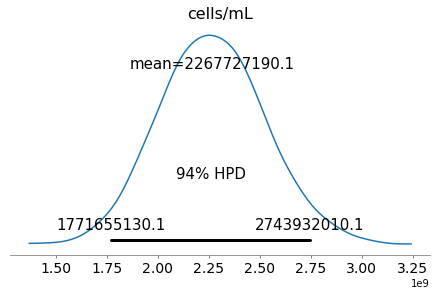

In [2]:
pm.plot_posterior(trace, varnames=['cells/mL'])

Experiment 2 growth over time

In [4]:
import pymc3 as pm
import numpy as np

MILLION = 1e6
TOTAL_SQUARES = 25
SQUARES_COUNTED = 4

yeast_counted =    np.array([20, 21,   28,   34, 34,   31,   32, 32])
hours_since_inoc = np.array([0,  12.5, 17.5, 23, 36.5, 42.5, 48, 65])
n_obs = yeast_counted.shape[0]


def logistic(t, K, r, delta_t):
    return K / (1 + np.exp(-r * (t - delta_t)))


with pm.Model() as model:

    K = pm.Normal("K", mu=50 * MILLION, sd=25 * MILLION) # about 50% growth was expected
    P0 = pm.Normal("P0", mu=100 * MILLION, sd=25 * MILLION)
    r = pm.Exponential("r", lam=2.5)
    delta_t = pm.Uniform("delta_t", lower=0, upper=24) # lag phase stops in the first 24 hours

    yeast_conc = P0 + logistic(hours_since_inoc, K, r, delta_t)

    flask1_volume = pm.Normal("flask1 volume (mL)", mu=9.0, sigma=0.05, shape=n_obs)
    flask2_volume = pm.Normal("flask2 volume (mL)", mu=9.0, sigma=0.05, shape=n_obs)

    yeast_slurry_volume = pm.Normal("initial yeast slurry volume (mL)", mu=1.0, sigma=0.01, shape=n_obs)
    flask1_to_flask2_volume =    pm.Normal("flask1 to flask2 (mL)", mu=1.0, sigma=0.01, shape=n_obs)

    dilution_flask1 = pm.Deterministic("dilution_flask1", yeast_slurry_volume  / (yeast_slurry_volume + flask1_volume))
    final_dilution_factor = pm.Deterministic("dilution_flask2", dilution_flask1 * flask1_to_flask2_volume / (flask1_to_flask2_volume + flask2_volume))

    volume_of_chamber = pm.Gamma("volume of chamber (mL)", mu=0.0001, sd=0.0001 / 20)

    # why is Poisson justified? in my final flask, I have yeast_conc * final_dilution_factor * flask2_volume number of yeast
    # I remove volume_of_chamber / flask2_volume fraction of them, hence it's a binomial with very high count, and very low probability.
    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * final_dilution_factor * volume_of_chamber, shape=n_obs)

    number_of_counted_cells = pm.Binomial("number of counted cells", yeast_visible, SQUARES_COUNTED/TOTAL_SQUARES, observed=yeast_counted, shape=n_obs)

    trace = pm.sample(2000, tune=20000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [volume of chamber (mL), flask1 to flask2 (mL), initial yeast slurry volume (mL), flask2 volume (mL), flask1 volume (mL), delta_t, r, P0, K]
>Metropolis: [cells in visible portion]
Sampling 2 chains: 100%|██████████| 44000/44000 [03:42<00:00, 198.10draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
